In [17]:
#DTW calculation

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from pylab import rcParams
from sklearn import metrics
from sklearn.model_selection import train_test_split
from scipy.ndimage import gaussian_filter
from scipy.fftpack import fft
from dtw import dtw
from numpy import array, zeros, argmin, inf, ndim
from scipy.spatial.distance import cdist
from sklearn.metrics.pairwise import manhattan_distances
%matplotlib inline

In [18]:
#read csv file and return its data-frame
def read_csv_file(acc, gyro, mode):
    df_gyro = pd.read_csv(gyro, index_col=False)
    df      = pd.read_csv(acc,  index_col=False)
    df.rename(columns = {'X': 'AX', 'Y':'AY', 'Z':'AZ'}, inplace = True)
    df['GX'] = df_gyro['X']
    df['GY'] = df_gyro['Y']
    df['GZ'] = df_gyro['Z']
    
    df['activity'] = mode
    
    return df

In [19]:
def plot_transportation_mod(transportation_mode, df):
    data = df[df['activity'] == transportation_mode][['AX', 'AY', 'AZ', 'GX', 'GY', 'GZ']][:8000]
    
    axis = data.plot(subplots = True, figsize =(20, 20), title = transportation_mode)
    
    for ax in axis:
        ax.legend(loc = 'lower left', bbox_to_anchor=(1.0,0.5))


In [20]:
def GaussianFilter(df, window_length):
    df1 = df
    df1['AX'] = gaussian_filter(df['AX'], window_length)
    df1['AY'] = gaussian_filter(df['AY'], window_length)
    df1['AZ'] = gaussian_filter(df['AZ'], window_length)

    df1['GX'] = gaussian_filter(df['GX'], window_length)
    df1['GY'] = gaussian_filter(df['GY'], window_length)
    df1['GZ'] = gaussian_filter(df['GZ'], window_length)
    
    return df1

In [21]:
def Mean(df, input_features, out_feature):
    df[out_feature] = (df[input_features[0]] + df[input_features[1]]  + df[input_features[2]])/3
    
    return df
    
    

In [22]:
#generate frequency domain data from time domain data usinf Fast Fourier transformation

def FFT(df, input_features, output_features):
   
    for i in range(len(input_features)):
        reals = np.real(np.fft.rfft(df[input_features[i]]))
        imagn = np.imag(np.fft.rfft(df[input_features[i]]))

        complexs = [reals[0]]
        n = len(reals)
        if(n%2 == 0):
            complexs.append(imagn[0])
        for j in range(1, n-1):
            complexs.append(reals[j])
            complexs.append(imagn[j])
        complexs.append(reals[j])
        if( len(df) > len(complexs)):
            complexs.append(imagn[j])
        df[output_features[i]] = complexs
    return df

In [23]:
def segmentation(df, N_TIME_STEPS):
    
    N_FEATURES = 1
    step = 50
    segments = []
    labels = []
    for i in range(0, len(df) - N_TIME_STEPS, step):
        gz = df['GZ'].values[i: i + N_TIME_STEPS]
        gy = df['GY'].values[i: i + N_TIME_STEPS]
    
        label = "ST"
        segments.append([gz,gy])
        labels.append(label)
    return segments, labels

In [139]:
def find_contiguous_colors(colors):
    # finds the continuous segments of colors and returns those segments
    segs = []
    curr_seg = []
    prev_color = ''
    for c in colors:
        if c == prev_color or prev_color == '':
            curr_seg.append(c)
        else:
            segs.append(curr_seg)
            curr_seg = []
            curr_seg.append(c)
        prev_color = c
    segs.append(curr_seg) # the final one
    return segs
 
def plot_multicolored_lines(x,y,colors):
    segments = find_contiguous_colors(colors)
    plt.figure(figsize=(10,2))
    start= 0
    for seg in segments:
        end = start + len(seg)
        l, = plt.gca().plot(x[start-1:end+1],y[start-1:end+1],lw=2,c=seg[0]) 
        start = end

In [25]:
def data_preprocessing(df):
    df['Milliseconds'] =df['Milliseconds']/1000 
    #apply gaussian filter with window size 5
    df = GaussianFilter(df, 5)
    
    #mean feature of 3-axis accelerometer data
    input_features = ['AX', 'AY', 'AZ']
    output_feature = 'mAcc'
    df = Mean(df, input_features, output_feature)
    
    #mean feature of 3-axis gyroscope data
    input_features = ['GX', 'GY', 'GZ']
    output_feature = 'mGyro'
    df = Mean(df, input_features, output_feature)
    
    #Frequency domain feature generation from time series accelerometer data
    input_features = ['AX', 'AY', 'AZ']
    output_feature = ['fAX', 'fAY', 'fAZ']
    df = FFT(df, input_features, output_feature)
    
    #Frequency domain feature generation from time series gyroscope data
    input_features = ['AX', 'AY', 'AZ']
    output_feature = ['fGX', 'fGY', 'fGZ']
    df = FFT(df, input_features, output_feature)
    
    return df
    
    
    
    
    

In [26]:
# def graph_plot():
#     x = np.arange(337)
#     y = np.arange(337)
#     plt.figure(figsize=(200,4))
#     fig,ax = plt.subplots(1)

#     ax.plot(x,y)
#     # Get current size
#     fig_size = plt.rcParams["figure.figsize"]

#     # Prints: [8.0, 6.0]
#     print ("Current size:", fig_size)

#     # Set figure width to 12 and height to 9
#     fig_size[0] = 20
#     fig_size[1] = 4
#     plt.rcParams["figure.figsize"] = fig_size
#     plt.plot(x,y)
#     print ("Current size:", fig_size)
#     major_ticks = np.arange(0, 337, 10)
#     minor_ticks = np.arange(0, 337, 5)
#     ax.set_xticks(major_ticks)
#     ax.set_xticks(minor_ticks, minor=True)

#     plt.grid(True)

In [27]:
# Function to map the colors as a list from the input list of x variables
def pltcolor(lst):
    cols=[]
    colors = {'ST':'blue', 'LT':'red','RT':'green'}
    for l in lst:
        cols.append(colors[l])      
    return cols

In [28]:
def dtw(x, y, dist, warp=1):
    """
    Computes Dynamic Time Warping (DTW) of two sequences.
    :param array x: N1*M array
    :param array y: N2*M array
    :param func dist: distance used as cost measure
    :param int warp: how many shifts are computed.
    Returns the minimum distance, the cost matrix, the accumulated cost matrix, and the wrap path.
    """
    assert len(x)
    assert len(y)
    r, c = len(x), len(y)
    D0 = zeros((r + 1, c + 1))
    D0[0, 1:] = inf
    D0[1:, 0] = inf
    D1 = D0[1:, 1:]  # view
    for i in range(r):
        for j in range(c):
            D1[i, j] = dist(x[i], y[j])
    C = D1.copy()
    for i in range(r):
        for j in range(c):
            min_list = [D0[i, j]]
            for k in range(1, warp + 1):
                i_k = min(i + k, r - 1)
                j_k = min(j + k, c - 1)
                min_list += [D0[i_k, j], D0[i, j_k]]
            D1[i, j] += min(min_list)
#     if len(x)==1:
#         path = zeros(len(y)), range(len(y))
#     elif len(y) == 1:
#         path = range(len(x)), zeros(len(x))
#     else:
#         path = _traceback(D0)
    return D1[-1, -1] / sum(D1.shape), C, D1

In [29]:
def DTWDistance(s1, s2, w):
    DTW={}

    w = max(w, abs(len(s1)-len(s2)))

    for i in range(-1,len(s1)):
        for j in range(-1,len(s2)):
            DTW[(i, j)] = float('inf')
    DTW[(-1, -1)] = 0

    for i in range(len(s1)):
        for j in range(max(0, i-w), min(len(s2), i+w)):
            dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])

    return (DTW[len(s1)-1, len(s2)-1])**(1/2)

In [30]:
def _traceback(D):
    i, j = array(D.shape) - 2
    p, q = [i], [j]
    while (i > 0) or (j > 0):
        tb = argmin((D[i, j], D[i, j+1], D[i+1, j]))
        if tb == 0:
            i -= 1
            j -= 1
        elif tb == 1:
            i -= 1
        else:  # (tb == 2):
            j -= 1
        p.insert(0, i)
        q.insert(0, j)
    return array(p), array(q)

In [31]:
def loss_for_segments(segments, comp, dist_fun):
    loss =[]
    length = len(segments)
    for i in range(length):
        x = segments[i][0]
        dist = DTWDistance(x, comp, 50)
        print(i , '=>', dist)
        loss.append(dist)
        
    return loss
    

In [37]:
#data for bike
acc_file = 'data/Bike2308/2018-08-23_16-18-07/Accelerometer.csv'
gyro_file= 'data/Bike2308/2018-08-23_16-18-07/Gyroscope.csv'

df_bike1 = read_csv_file(acc_file, gyro_file, 'bike')

n = len(df_bike1)
print("shape -", df_bike1.shape)

df_bike = df_bike1[4000 : 5000]

df_bike.reset_index(drop = True, inplace = True)
df_bike = data_preprocessing(df_bike)
print("shape -", df_bike.shape)
df_bike.head()


shape - (14390, 8)


/home/vicky/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/vicky/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/vicky/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


shape - (1000, 16)


/home/vicky/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/vicky/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Milliseconds,AX,AY,AZ,GX,GY,GZ,activity,mAcc,mGyro,fAX,fAY,fAZ,fGX,fGY,fGZ
0,80.001,-0.487817,-1.582395,-9.808804,0.001068,-0.023723,0.017084,bike,-3.959672,-0.001857,-722.537475,-1751.198015,-10049.871378,-722.537475,-1751.198015,-10049.871378
1,80.022,-0.495048,-1.593013,-9.820598,0.000228,-0.024048,0.017265,bike,-3.969553,-0.002185,67.974706,79.756800,31.641444,67.974706,79.756800,31.641444
2,80.041,-0.508958,-1.613352,-9.842144,-0.001416,-0.024709,0.017556,bike,-3.988151,-0.002856,158.561932,336.949599,-65.945583,158.561932,336.949599,-65.945583
3,80.062,-0.528426,-1.641753,-9.869807,-0.003771,-0.025713,0.017832,bike,-4.013328,-0.003884,-62.229706,-81.528545,-6.223701,-62.229706,-81.528545,-6.223701
4,80.081,-0.551947,-1.675921,-9.899074,-0.006721,-0.027065,0.017946,bike,-4.042314,-0.005280,30.511636,-1.424239,3.051393,30.511636,-1.424239,3.051393


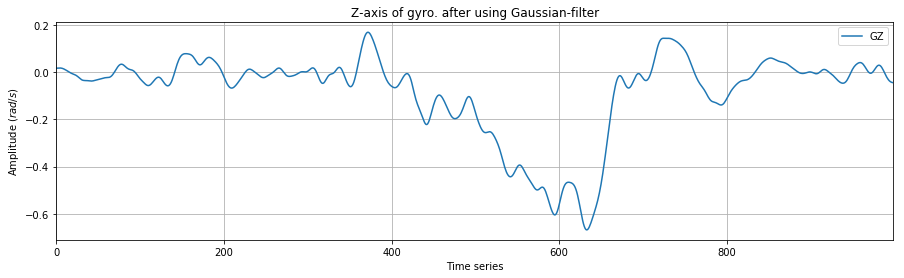

In [60]:
df_bike[['GZ']].plot(figsize = (15,4), title = "Z-axis of gyro. after using Gaussian-filter")
plt.xlabel('Time series')
plt.ylabel('Amplitude ($rad/s$)')
plt.grid("true")
plt.savefig("noise_reduced_gyro.png")

In [24]:
# #data for bike
# acc_file = 'data/Bike2308/2018-08-23_16-15-15/AccelerometerLinear.csv'
# gyro_file= 'data/Bike2308/2018-08-23_16-15-15/Gyroscope.csv'

# df_bike1 = read_csv_file(acc_file, gyro_file, 'bike')

# n = len(df_bike1)
# print("shape -", df_bike1.shape)

# df_bike1 = df_bike1[1000 : n-1000]

# df_bike1.reset_index(drop = True, inplace = True)
# df_bike1 = data_preprocessing(df_bike1)
# print("shape -", df_bike1.shape)
# df_bike1.head()



shape - (7601, 8)
shape - (5601, 16)


,Milliseconds,AX,AY,AZ,GX,GY,GZ,activity,mAcc,mGyro,fAX,fAY,fAZ,fGX,fGY,fGZ
0,20.001,0.064721,-0.338482,-0.036086,0.030317,0.000798,-0.028652,bike,-0.103282,0.000821,214.572877,-853.945574,17.673453,214.572877,-853.945574,17.673453
1,20.022,0.063199,-0.340854,-0.035360,0.029147,0.002519,-0.028442,bike,-0.104338,0.001075,6.900917,194.611244,11.728499,6.900917,194.611244,11.728499
2,20.041,0.060563,-0.345927,-0.034363,0.026951,0.005847,-0.028004,bike,-0.106576,0.001598,81.623407,136.747128,42.528071,81.623407,136.747128,42.528071
3,20.061,0.057548,-0.354286,-0.033995,0.023963,0.010540,-0.027313,bike,-0.110244,0.002397,49.650241,-325.385333,65.387126,49.650241,-325.385333,65.387126
4,20.082,0.054883,-0.366660,-0.035180,0.020476,0.016250,-0.026345,bike,-0.115652,0.003460,-245.438437,-28.728289,-83.593948,-245.438437,-28.728289,-83.593948


In [25]:
# print("shape -", df_bike.shape)
# print("shape -", df_bike1.shape)

# df = pd.concat([df_bike, df_bike1])
# df.reset_index(drop = True, inplace = True)
# n = len(df)
# print("shape -", df.shape)
# df.head()

shape - (12413, 16)
shape - (5601, 16)
shape - (18014, 16)


,Milliseconds,AX,AY,AZ,GX,GY,GZ,activity,mAcc,mGyro,fAX,fAY,fAZ,fGX,fGY,fGZ
0,20.001,-0.344690,0.352213,-0.131941,-0.045794,-0.007894,0.566408,bike,-0.041472,0.170907,-610.554514,-1338.440613,88.325471,-610.554514,-1338.440613,88.325471
1,20.021,-0.325112,0.353453,-0.125852,-0.045373,-0.007476,0.564057,bike,-0.032503,0.170403,134.212886,67.370358,40.923363,134.212886,67.370358,40.923363
2,20.041,-0.287051,0.355392,-0.113982,-0.044581,-0.006686,0.559156,bike,-0.015213,0.169296,-30.141141,-59.956886,-20.362319,-30.141141,-59.956886,-20.362319
3,20.062,-0.232431,0.357122,-0.096918,-0.043502,-0.005623,0.551344,bike,0.009258,0.167406,155.770975,129.440046,-8.727666,155.770975,129.440046,-8.727666
4,20.081,-0.164102,0.357596,-0.075456,-0.042231,-0.004415,0.540164,bike,0.039346,0.164506,-217.732865,-192.100957,64.886329,-217.732865,-192.100957,64.886329


NameError: name 'df_bike1' is not defined

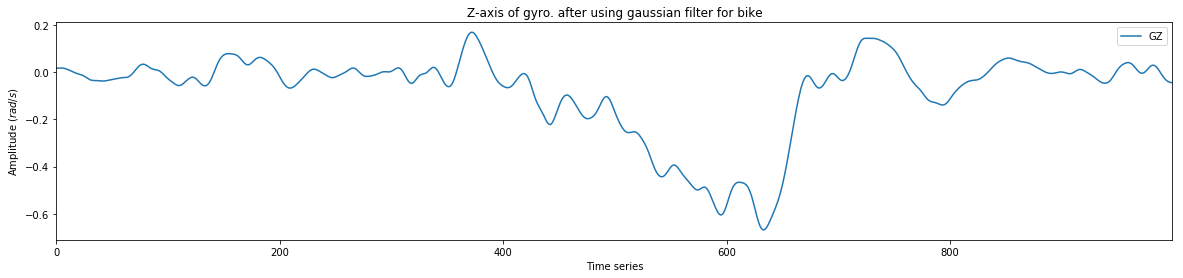

In [34]:
df_bike[['GZ']].plot(figsize = (20,4), title = "Z-axis of gyro. after using gaussian filter for bike")
plt.xlabel('Time series')
plt.ylabel('Amplitude ($rad/s$)')

df_bike1[['GZ']].plot(figsize = (20,4), title = "Z-axis of gyro. after using gaussian filter for bike")
plt.xlabel('Time series')
plt.ylabel('Amplitude ($rad/s$)')

fig, ax = plt.subplots()
df[['GZ']].plot(figsize = (20,4),ax=ax, title = "Z-axis of gyro. after using gaussian filter for bike")
plt.xlabel('Time series')
plt.ylabel('Amplitude ($rad/s$)')
major_ticks = np.arange(0, n, 500)
minor_ticks = np.arange(0, n, 250)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
fig.savefig('abc.png') 

plt.grid(True)

In [181]:
bike_segments, bike_labels = segmentation(df_bike1, 400)
np.array(bike_segments).shape
bike_labels[0:1] = ["LT"] * (1)
# bike_labels[5:13] = ["LT"] * (13-5)
# x = bike_segments[100][0]
# xx = pd.Series(x)
# xx.plot(figsize = (7,3))

In [120]:
dist_fun = manhattan_distances
ref  = [0.0]*400
len(ref)
diff_wrt_ST_bike = loss_for_segments(bike_segments, ref ,dist_fun)
loss_series = pd.Series(diff_wrt_ST_bike)
loss_series.to_csv('diff_wrt_ST_bike')

0 => 23.8919881884
1 => 24.8258786493
2 => 20.4991448981
3 => 17.6906588553
4 => 15.7486489007
5 => 15.3818454269
6 => 10.1409658376
7 => 8.52557930512
8 => 8.00771975263
9 => 4.30524222522
10 => 1.32125454319
11 => 2.05767184055
12 => 3.06181854821
13 => 3.70404880646
14 => 3.87908472057
15 => 4.12437090354
16 => 4.16018849971
17 => 4.37456885515
18 => 4.64984108349
19 => 4.70578441019
20 => 4.21648506439
21 => 3.73278037902
22 => 3.68931131761
23 => 3.43446179648
24 => 3.41196981128
25 => 3.16940031901
26 => 2.58406136778
27 => 1.94598949356
28 => 1.77725421057
29 => 1.7835048572
30 => 1.69588847194
31 => 1.74694534204
32 => 1.8149859987
33 => 1.8265984256
34 => 1.79118227665
35 => 1.77260317009
36 => 1.8384662791
37 => 1.74046832017
38 => 1.54163808822
39 => 1.49150319444
40 => 1.4121066214
41 => 1.51518606554
42 => 1.54087857006
43 => 1.65956498534
44 => 1.59678576677
45 => 1.64751561396
46 => 1.67191952155
47 => 1.64667113862
48 => 1.64628290499
49 => 1.52276178314
50 => 1.5941507

In [121]:
# print(np.array(diff_wrt_ST_bike).shape)
# diff_wrt_ST_bike = [*zip(diff_wrt_ST_bike)]
# print(np.array(diff_wrt_ST_bike).shape)

In [122]:
# import csv
# with open("DTW_data_bike.csv","w+") as my_csv:
#     csvWriter = csv.writer(my_csv,delimiter=',')
#     csvWriter.writerows(diff_wrt_ST_bike)

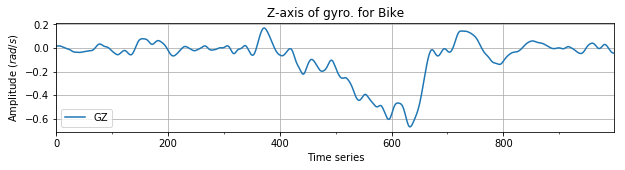

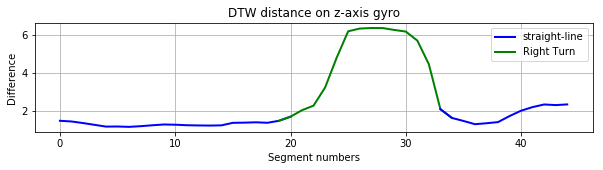

In [183]:
fig, ax = plt.subplots()
n = len(df_bike)
df_bike[['GZ']].plot(figsize = (10,2),ax=ax, title = "Z-axis of gyro. for Bike")
plt.xlabel('Time series')
plt.ylabel('Amplitude ($rad/s$)')

major_ticks = np.arange(0, n, 200)
minor_ticks = np.arange(0, n, 100)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
plt.grid(True)

bike_labels[20:34] = ["RT"]*(34-20)

bike_colors = pltcolor(bike_labels)

legend_elements = [Line2D([0], [0], color='b', lw=2, label='straight-line'),
                   Line2D([0], [0], color='g', lw=2, label='Right Turn')]
y = loss_series[60:105]
x = np.arange(len(y))
plot_multicolored_lines(x,y,bike_colors)
plt.xlabel('Segment numbers')
plt.ylabel('Difference')
plt.title("DTW distance on z-axis gyro")
plt.legend(handles=legend_elements, loc='upper right')
plt.grid(True)
plt.show()

In [ ]:
dist_fun = manhattan_distances
y = bike_segments[67][0]
diff_wrt_LT_bike = loss_for_segments(bike_segments, y ,dist_fun)
loss_series_LT = pd.Series(diff_wrt_LT_bike)
loss_series_LT.to_csv('diff_wrt_LT_bike')

In [ ]:
print(np.array(bike_dtw_data).shape)

bike_dtw_data = [*zip(*bike_dtw_data)]

print(np.array(bike_dtw_data).shape)



In [46]:
legend_elements = [Line2D([0], [0], color='b', lw=2, label='straight-line'),
                   Line2D([0], [0], color='r', lw=2, label='Right Turn'),
                   Line2D([0], [0], color='g', lw=2, label='Left Turn')]

y = loss_series_ST
x = np.arange(len(y))
plot_multicolored_lines(x,y,bike_colors)
plt.xlabel('Segment numbers')
plt.ylabel('Difference')

plt.legend(handles=legend_elements, loc='upper right')

plt.grid(True)
plt.show()

NameError: name 'loss_series_ST' is not defined

In [161]:

dist_fun = manhattan_distances
y = bike_segments[100][0]
diff_wrt_RT_bike = loss_for_segments(bike_segments, y ,dist_fun)
loss_series_RT = pd.Series(diff_wrt_RT_bike)
loss_series_RT.to_csv('diff_wrt_LT_bike')

0 => 0.0535049492916
1 => 0.0420573697782
2 => 0.0383567872327
3 => 0.0342812484138
4 => 0.0300340800523
5 => 0.0256037810288
6 => 0.0384885895645
7 => 0.0362818734628
8 => 0.0428391712854
9 => 0.039763222882
10 => 0.0485188792267
11 => 0.0480082970729
12 => 0.0475089993274
13 => 0.0466773242147
14 => 0.0472584807912
15 => 0.049620904128
16 => 0.0510635780214
17 => 0.0499046873683
18 => 0.0500447503402
19 => 0.0566387742979
20 => 0.054664078931
21 => 0.0518838883437
22 => 0.0502878282278
23 => 0.0481131545159
24 => 0.0467488710231
25 => 0.0484885637453
26 => 0.0487070509463
27 => 0.0487014369426
28 => 0.050534188814
29 => 0.0530597006653
30 => 0.0516165336086
31 => 0.050193758457
32 => 0.0505590617433
33 => 0.0522187294818
34 => 0.0526612384931
35 => 0.0504587078958
36 => 0.0505695477079
37 => 0.0488154533284
38 => 0.0423761636983
39 => 0.04296735896
40 => 0.0402307016608
41 => 0.041321656191
42 => 0.0606730901522
43 => 0.0591859491328
44 => 0.0573252225288
45 => 0.0564620637496
46 => 

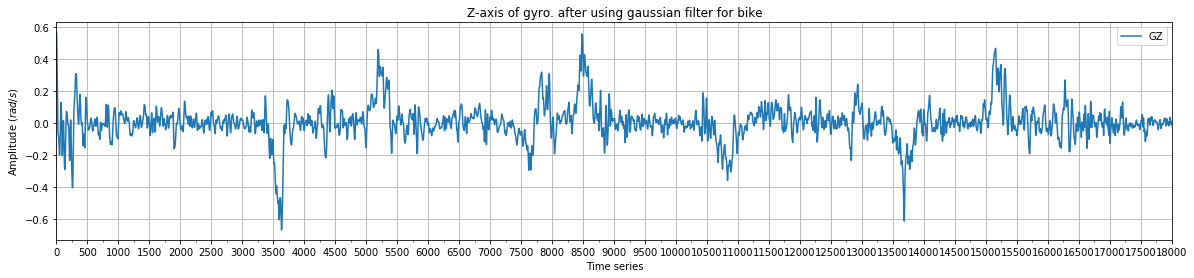

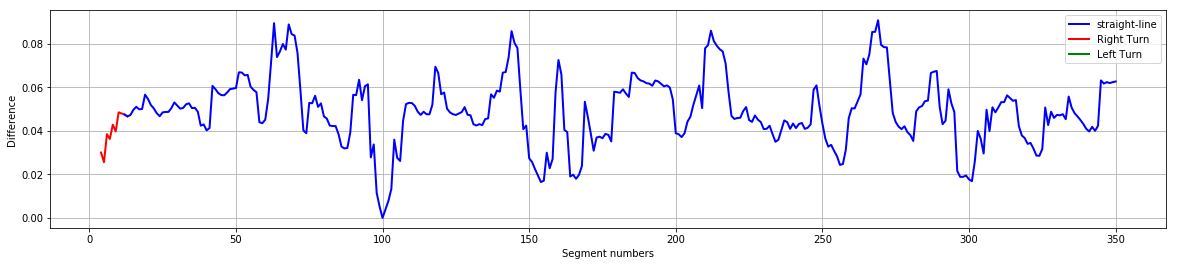

In [163]:
fig, ax = plt.subplots()
df[['GZ']].plot(figsize = (20,4),ax=ax, title = "Z-axis of gyro. after using gaussian filter for bike")
plt.xlabel('Time series')
plt.ylabel('Amplitude ($rad/s$)')
major_ticks = np.arange(0, n, 500)
minor_ticks = np.arange(0, n, 250)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
fig.savefig('abc.png') 

plt.grid(True)

legend_elements = [Line2D([0], [0], color='b', lw=2, label='straight-line'),
                   Line2D([0], [0], color='r', lw=2, label='Right Turn'),
                   Line2D([0], [0], color='g', lw=2, label='Left Turn')]

y = loss_series_RT
x = np.arange(len(y))
plot_multicolored_lines(x,y,bike_colors)
plt.xlabel('Segment numbers')
plt.ylabel('Difference')

plt.legend(handles=legend_elements, loc='upper right')

plt.grid(True)
plt.show()
